# TensorFlow Transfer Learning

Transfer Learning is taking a model that has been pre-trained on another data set and applying it our dataset

## Where to get Pre-Trained Models?

There 2 primary locations

- Tensorflow's own libraries
 - `tensorflow.keras.applications`
 - https://www.tensorflow.org/api_docs/python/tf/keras/applications

- TensorFlow Hub
 - https://tfhub.dev/
 - Directly integrates into Colab
 - `import tensorflow_hub as hub`


### Getting Started

Dataset:

- https://www.kaggle.com/datasets/gpiosenka/balls-image-classification

### Normalizing and Batching

With pre-trained models we can take advantage of `image_dataset_from_directory` which allows for faster processing

- The downside is that we don't get a dictionary with `class_indices`
- We have to create our own

If we are using a model that has a Rescaling layer built in (EfficientNetBX, )

```
train_data = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(224,224),
    shuffle=True
)
```

Get class_indices

`class_indices = dict(zip(test_data.class_names, np.arange(len(test_data.class_names)))`

For other models such as VGG, or ResNet, they include their own `preprocess_input`

```
# Prepend the TL Model
i = tf.keras.layers.Input([TARGET_SIZE, TARGET_SIZE, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)

# Layer that resizes in most other TL Models
x = tf.keras.applications.VGG16.preprocess_input(x)

# Instantiate the TL Model
core = tf.keras.applications.VGG16()

x = core(x)

# Create the actual Model
model = tf.keras.Model(inputs=[i], outputs=[x])
```


### Building the Model

In this example we are using EfficientNet because it already scales data for us

```
base_model = EfficientNetB0()

output = Dense(26, activation='softmax')(base_model.output)

model = Model(base_model.input, output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

```

By default all layers are going to be Trainable

#### Trainable

True (default) 
- The weights will adapt to the dataset
- Results in slower performance due to updating weights

False
- The weights will be static
- Results in faster training

### Predictions

Depending on TL Model used, we may or may not have to resize the images

```
# No need to rescale for EfficientNet
# Rescale if model is not EfficientNet

y_true = []
preds = []

def predictor(path, image):
  target = path + '/' + image
  category = path.split('/')[1]

  img = tf.io.read_file(target)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [224,224])

  # img = img/255.

  img = tf.expand_dims(img, axis=0)

  pred = np.argmax(model_8.predict(img), axis=1)
  preds.append(pred[0])

  if category in class_indices.keys():
    y_true.append(class_indices[category])

for dirs, fols, files in os.walk('test'):
  if len(fols) < 1:
    for file in files:
      predictor(dirs, file)

# Plot the Confusion Matrix and print the Classification Report
sns.heatmap(confusion_matrix(y_true, preds), annot=True)

print(classification_report(y_true, preds))
```

### Speeding up Training Techniques

#### Mixed Precision

Global Setting

Majority of the time all calucations are done with a 32-bit floating point number.  Since not all numbers have to be 32-bit, then we can take advantage of a smaller compute size to save time, 16-bit floating point

- This method requires a change in the construction of the model

```
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Output layers of the model
x = Dense(10, name='dense_logits')(x)
outputs = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
```

#### Prefetch Batched Data

In the Batch and preprocessing of the data we can prefetch and cache the next batch of image data

With this method we want to create another dataset to retain the class_names

```
train_data_pre_fetch = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_data_pre_fetch = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
```


### Import Libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
import random
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import confusion_matrix, classification_report

import zipfile

In [89]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [90]:
!nvidia-smi

Sat Jul 16 08:22:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |   4904MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Connect Colab to Kaggle and Get Dataset

- Download and unzip the Dataset

- https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d gpiosenka/balls-image-classification

 92% 169M/183M [00:02<00:00, 67.0MB/s]
100% 183M/183M [00:02<00:00, 68.5MB/s]


In [6]:
uz = zipfile.ZipFile('balls-image-classification.zip')
uz.extractall()
uz.close()

### Explore the Data

- How many images?
- What is the size of the images?
- What percent do we need to be above?

In [7]:
total = 0

for dirs, fols, files in os.walk('train'):
  print(f'{dirs}, {len(fols)}, {len(files)}')
  if len(fols) < 1:
    total += len(files)
total

train, 26, 0
train/pokeman balls, 0, 86
train/baseball, 0, 112
train/tennis ball, 0, 139
train/volley ball, 0, 131
train/meat ball, 0, 137
train/marble, 0, 131
train/paint balls, 0, 32
train/golf ball, 0, 106
train/medicine ball, 0, 77
train/football, 0, 112
train/brass, 0, 113
train/bowling ball, 0, 145
train/eyeballs, 0, 139
train/cannon ball, 0, 183
train/water polo ball, 0, 139
train/basketball, 0, 116
train/soccer ball, 0, 167
train/billiard ball, 0, 143
train/puffballs, 0, 106
train/screwballs, 0, 140
train/cricket ball, 0, 150
train/wrecking ball, 0, 69
train/beachballs, 0, 92
train/wiffle ball, 0, 99
train/tether ball, 0, 105
train/buckeyballs, 0, 82


3051

In [8]:
print(3051/26)

117.34615384615384


In [9]:
print(117/3051)

0.038348082595870206


(224, 224, 3)


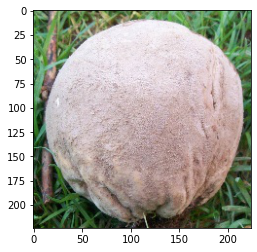

In [23]:
path = 'train/'
category = 'puffballs/'

target = path + category
image = random.choice(os.listdir(target))

img = mpimage.imread(target + image)
print(img.shape)

plt.imshow(img)

### Noramlize and Batch the Data

- Use image_dataset_from_directory

In [91]:
train_dir = 'train/'
test_dir = 'test/'

# We don't need a rescaling option for today because we are using pre-defined models

train_data = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
)

# Shorthand version
test_data = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(224,224),
)


train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3051 files belonging to 26 classes.
Found 130 files belonging to 26 classes.


In [28]:
item = train_data.take(1)

In [31]:
for i in item:
  print(i)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[110., 207., 223.],
         [108., 206., 219.],
         [114., 207., 222.],
         ...,
         [121., 158., 185.],
         [122., 156., 183.],
         [123., 157., 184.]],

        [[ 93., 196., 213.],
         [ 92., 195., 210.],
         [ 96., 198., 213.],
         ...,
         [122., 158., 184.],
         [124., 158., 185.],
         [127., 159., 184.]],

        [[ 75., 192., 212.],
         [ 75., 192., 210.],
         [ 78., 195., 213.],
         ...,
         [124., 156., 179.],
         [126., 156., 180.],
         [127., 157., 181.]],

        ...,

        [[  9.,  66.,  59.],
         [  8.,  69.,  61.],
         [  4.,  67.,  58.],
         ...,
         [255., 223.,  63.],
         [254., 223.,  73.],
         [245., 217.,  73.]],

        [[  6.,  69.,  61.],
         [  7.,  70.,  62.],
         [  8.,  69.,  62.],
         ...,
         [247., 212.,  24.],
         [254., 219.,  31.],
       

In [92]:
test_data.class_names

AttributeError: ignored

In [35]:
# Since image_dataset_from_directory does not provide a dictionary of directories to labels
# We have to create our own

class_names = dict(zip(
    test_data.class_names,
    np.arange(len(test_data.class_names))
))

In [36]:
class_names

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

### 1st Model - EfficientNet Default

- Create a model with EfficientNetB0 with Defaults

- Add in the Dense Layer

- Build the model and look at the summary

- Train the Model

In [37]:
from tensorflow.keras.applications import  EfficientNetB0

In [43]:
# Traditional way of creating a model

# model_1 = Sequential()

# model_1.add(Dense(10,actiavtion='relu'))
# model_1.add(Dense(10,actiavtion='relu'))
# model_1.add(Dense(10,actiavtion='relu'))
# model_1.add(Dense(1,actiavtion='sigmoid'))


base_model = EfficientNetB0()

# len(base_model.layers)


# base_model.output becomes the input for the Dense Layer
# We put that into an output variable
output = Dense(26, activation='softmax')(base_model.output)

model_1 = Model(inputs=base_model.input, outputs=output)

model_1.build(input_shape=(224,224,3))


model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 55s 361ms/step - loss: 3.1631 - accuracy: 0.6060 - val_loss: 3.1225 - val_accuracy: 0.5769
Epoch 2/5
96/96 [==============================] - 31s 323ms/step - loss: 3.0389 - accuracy: 0.6932 - val_loss: 3.0593 - val_accuracy: 0.4923
Epoch 3/5
96/96 [==============================] - 32s 328ms/step - loss: 2.9338 - accuracy: 0.6867 - val_loss: 3.0110 - val_accuracy: 0.4923
Epoch 4/5
96/96 [==============================] - 32s 328ms/step - loss: 2.8390 - accuracy: 0.6929 - val_loss: 2.9769 - val_accuracy: 0.4769
Epoch 5/5
96/96 [==============================] - 31s 325ms/step - loss: 2.7536 - accuracy: 0.6699 - val_loss: 2.7826 - val_accuracy: 0.6154


In [42]:
len(base_model.layers)

240

In [41]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              

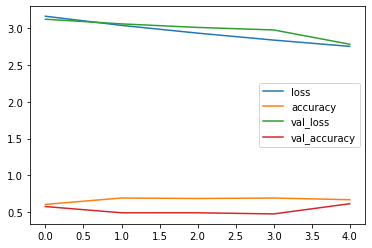

In [45]:
pd.DataFrame(history_1.history).plot()

### 2nd Model - EfficientNet Trainable False

- Disable Training on all Layers

- What is the difference in time between the first and second model?

In [50]:
base_model = EfficientNetB0()

# Disable the default training behavior
for layer in base_model.layers:
  layer.trainable = False
  print(layer, layer.trainable)

output = Dense(26, activation='softmax')(base_model.output)

model_2 = Model(base_model.input, output)

model_2.build(input_shape=(224,224,3))

# print(base_model.input)
# print(base_model.output)

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

<keras.engine.input_layer.InputLayer object at 0x7fc35669fe50> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fc33428fa10> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7fc3342cdc50> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fc306eeaed0> False
<keras.layers.convolutional.Conv2D object at 0x7fc33428e3d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc3c01d3e90> False
<keras.layers.core.activation.Activation object at 0x7fc33f080d10> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fc334290250> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc306e9cdd0> False
<keras.layers.core.activation.Activation object at 0x7fc335f1d590> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc3342dd610> False
<keras.layers.core.reshape.Reshape object at 0x7fc335f9be50> False
<keras.layers.convolutional.Conv2D object at 0x7

In [47]:
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

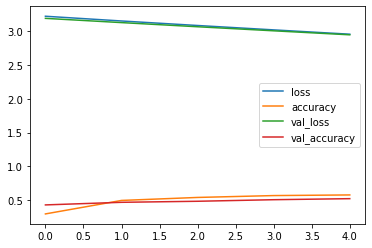

In [51]:
pd.DataFrame(history_2.history).plot()

### 3rd Model - EfficientNet - Include Top False

- Include Top: False
- Have to specify Input Shape
- Have to have some kind of pooling, either max or average
 - can change it in the model or add a layer
 - 'avg' is the default with include_top
- Disable Training on all layers

In [58]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation='softmax'
)

for layer in base_model.layers:
  layer.trainable = False

output = Dense(26, activation='softmax')(base_model.output)

model_3 = Model(base_model.inputs, output)

model_3.build(input_shape=(224,224,3))

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 14s 89ms/step - loss: 1.2721 - accuracy: 0.7443 - val_loss: 0.4439 - val_accuracy: 0.9154
Epoch 2/5
96/96 [==============================] - 8s 77ms/step - loss: 0.3406 - accuracy: 0.9440 - val_loss: 0.2411 - val_accuracy: 0.9538
Epoch 3/5
96/96 [==============================] - 8s 76ms/step - loss: 0.2117 - accuracy: 0.9617 - val_loss: 0.1718 - val_accuracy: 0.9692
Epoch 4/5
96/96 [==============================] - 8s 76ms/step - loss: 0.1506 - accuracy: 0.9725 - val_loss: 0.1402 - val_accuracy: 0.9692
Epoch 5/5
96/96 [==============================] - 7s 76ms/step - loss: 0.1154 - accuracy: 0.9830 - val_loss: 0.1187 - val_accuracy: 0.9692


In [55]:
model_3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_9 (Rescaling)        (None, None, None,   0           ['input_10[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_9 (Normalization  (None, None, None,   7          ['rescaling_9[0][0]']            
 )                              3)                                                          

In [60]:
model_3.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_12 (Rescaling)       (None, None, None,   0           ['input_13[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_12 (Normalizatio  (None, None, None,   7          ['rescaling_12[0][0]']           
 n)                             3)                                                         

In [61]:
len(base_model.layers)

238

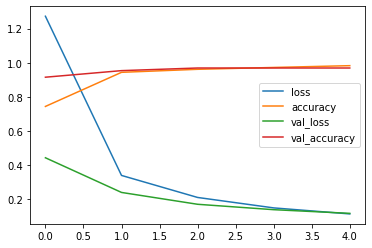

In [59]:
pd.DataFrame(history_3.history).plot()

### 4th Model - EfficientNet - Top False w/ Extra Dense Layer

- Add an extra Dense layer with 1000 units before the output layer

In [72]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
)

for layer in base_model.layers:
  layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1000, activation='relu')(x)

output = Dense(26, activation='softmax')(x)

model_4 = Model(base_model.input, output)

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 14s 90ms/step - loss: 0.5002 - accuracy: 0.8604 - val_loss: 0.1614 - val_accuracy: 0.9462
Epoch 2/5
96/96 [==============================] - 8s 77ms/step - loss: 0.0743 - accuracy: 0.9780 - val_loss: 0.0892 - val_accuracy: 0.9615
Epoch 3/5
96/96 [==============================] - 8s 77ms/step - loss: 0.0372 - accuracy: 0.9905 - val_loss: 0.0617 - val_accuracy: 0.9769
Epoch 4/5
96/96 [==============================] - 8s 77ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.0629 - val_accuracy: 0.9769
Epoch 5/5
96/96 [==============================] - 8s 77ms/step - loss: 0.0099 - accuracy: 0.9987 - val_loss: 0.0634 - val_accuracy: 0.9769


In [69]:
model_4.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_15 (Rescaling)       (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 normalization_15 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_15[0][0]']           
 n)                                                                                               
                                                                                           

### Run evaluations and predictions

- Use Model 4

In [78]:
path = 'test/'
category='beachballs/'
target = path + category

image = random.choice(os.listdir(target))

img = tf.io.read_file(target + image)
img = tf.io.decode_image(img)
img = tf.image.resize(img, [224,224])

img = tf.expand_dims(img, axis=0)

np.argmax(model_4.predict(img), axis=1)

array([2])

In [79]:
class_names

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

In [80]:
y_true = []
predictions = []

def predictor(path, image):
  
  target = path + '/' + image
  category = path.split('/')[1]

  img = tf.io.read_file(target)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [224,224])

  img = tf.expand_dims(img, axis=0)

  pred = np.argmax(model_4.predict(img), axis=1)
  predictions.append(pred[0])

  y_true.append(class_names[category])


In [81]:
for dirs, fols, files in os.walk('test'):
  if len(fols) < 1:
    for file in files:
      predictor(dirs, file)

In [82]:
len(y_true) == len(predictions)

True

In [83]:
set(y_true) == set(predictions)

True

In [84]:
import seaborn as sns

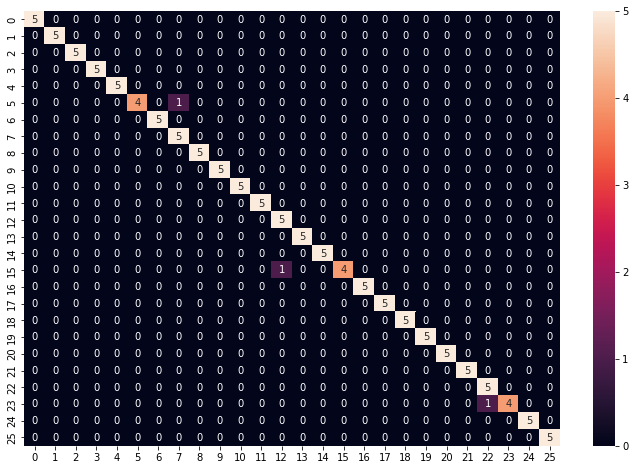

In [86]:

plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_true, predictions), annot=True)

In [87]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [88]:
class_names

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

In [93]:
# VGG application because we don't have rescaling in the model

from tensorflow.keras.applications import VGG16


In [100]:
i = tf.keras.layers.Input([224, 224, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)

x = tf.keras.applications.vgg16.preprocess_input(x)

base_model = tf.keras.applications.VGG16()

for layer in base_model.layers:
  layer.trainable = False

x = base_model(x)

output = Dense(26, activation='softmax')(x)


model_5 = tf.keras.Model(inputs=[i], outputs=output)

model_5.build(input_shape=(224,224,3))

model_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5 = model_5.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 15s 119ms/step - loss: 3.2229 - accuracy: 0.2540 - val_loss: 3.1915 - val_accuracy: 0.3462
Epoch 2/5
96/96 [==============================] - 10s 105ms/step - loss: 3.1421 - accuracy: 0.4726 - val_loss: 3.1230 - val_accuracy: 0.3692
Epoch 3/5
96/96 [==============================] - 10s 100ms/step - loss: 3.0643 - accuracy: 0.5362 - val_loss: 3.0559 - val_accuracy: 0.4692
Epoch 4/5
96/96 [==============================] - 10s 99ms/step - loss: 2.9884 - accuracy: 0.5926 - val_loss: 2.9913 - val_accuracy: 0.4923
Epoch 5/5
96/96 [==============================] - 9s 98ms/step - loss: 2.9149 - accuracy: 0.5991 - val_loss: 2.9275 - val_accuracy: 0.5077


In [97]:
model_5.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_25 (Dense)            (None, 26)                26026     
                                                          

In [99]:
model_5.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_2 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_26 (Dense)            (None, 26)                260